# PRs for RB performance improvement
The main PR:
- New algorithm for RB building Cliffords by layers [#892](https://github.com/Qiskit/qiskit-experiments/pull/892)

Follow-up PRs:
- Improve custom transpilation for faster 1Q/2Q RB [#922](https://github.com/Qiskit/qiskit-experiments/pull/922)
- Improve integer-based Clifford operations for 1Q/2Q RB [#940](https://github.com/Qiskit/qiskit-experiments/pull/940)

All those PRs were merged into a feature branch `rb_speedup` and will be merged into `main` soon.

# How the implementation is improved

### Custom transpilation
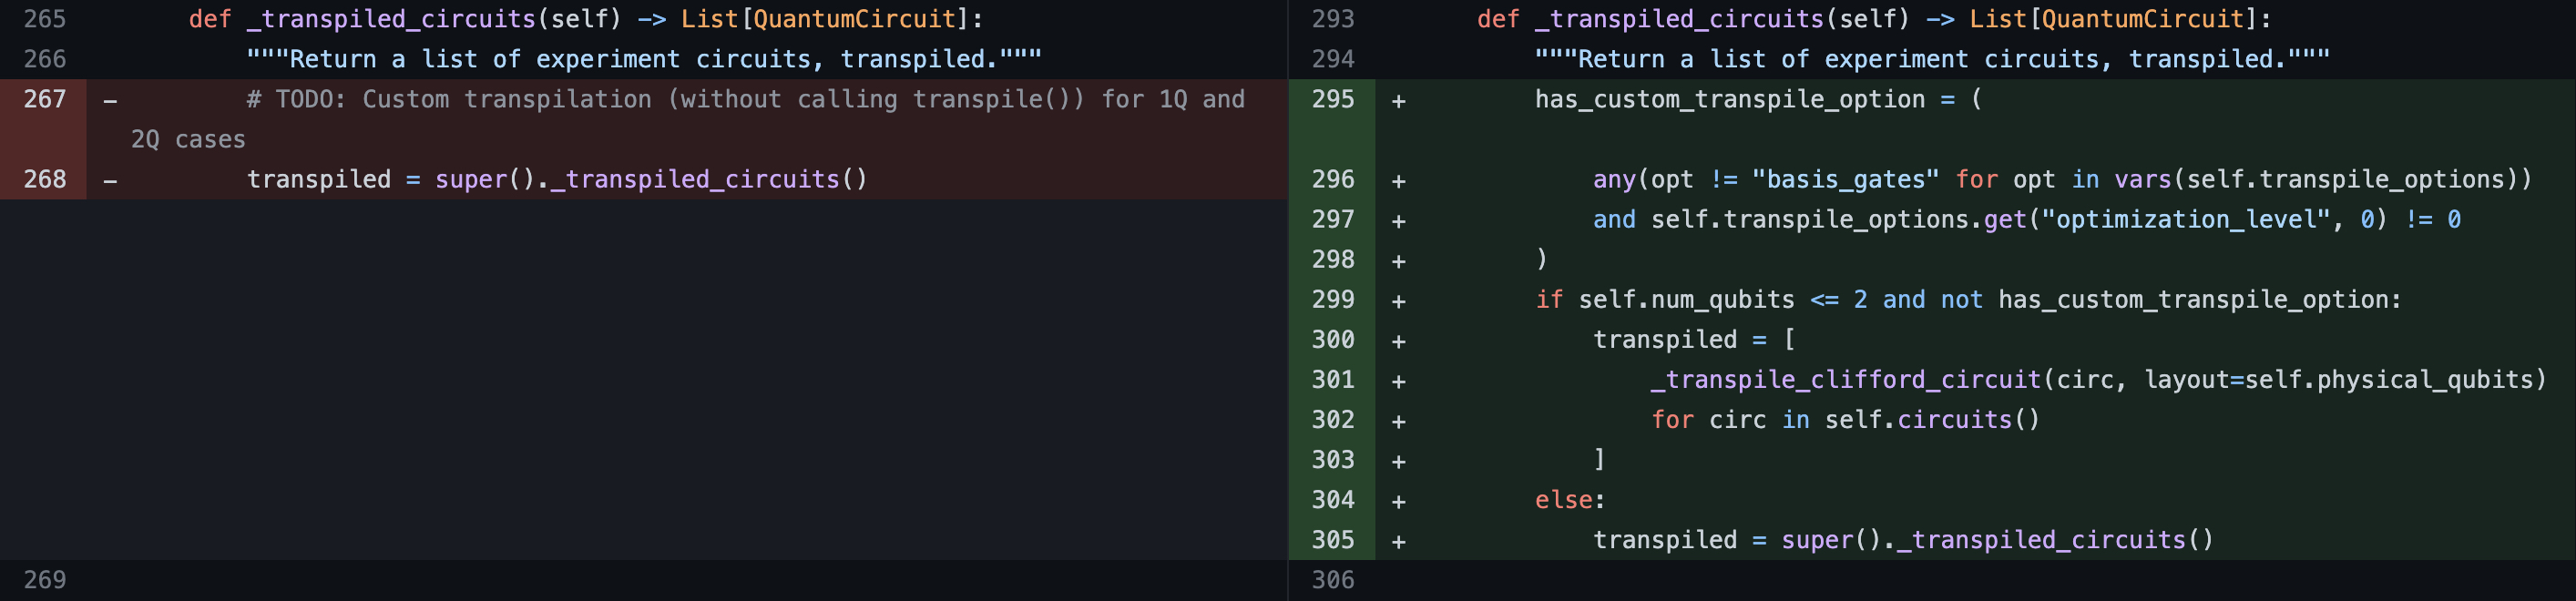

`super()._transpile_circuits()` ~= just calling terra's `transpile()`

### Integer-based Clifford operations
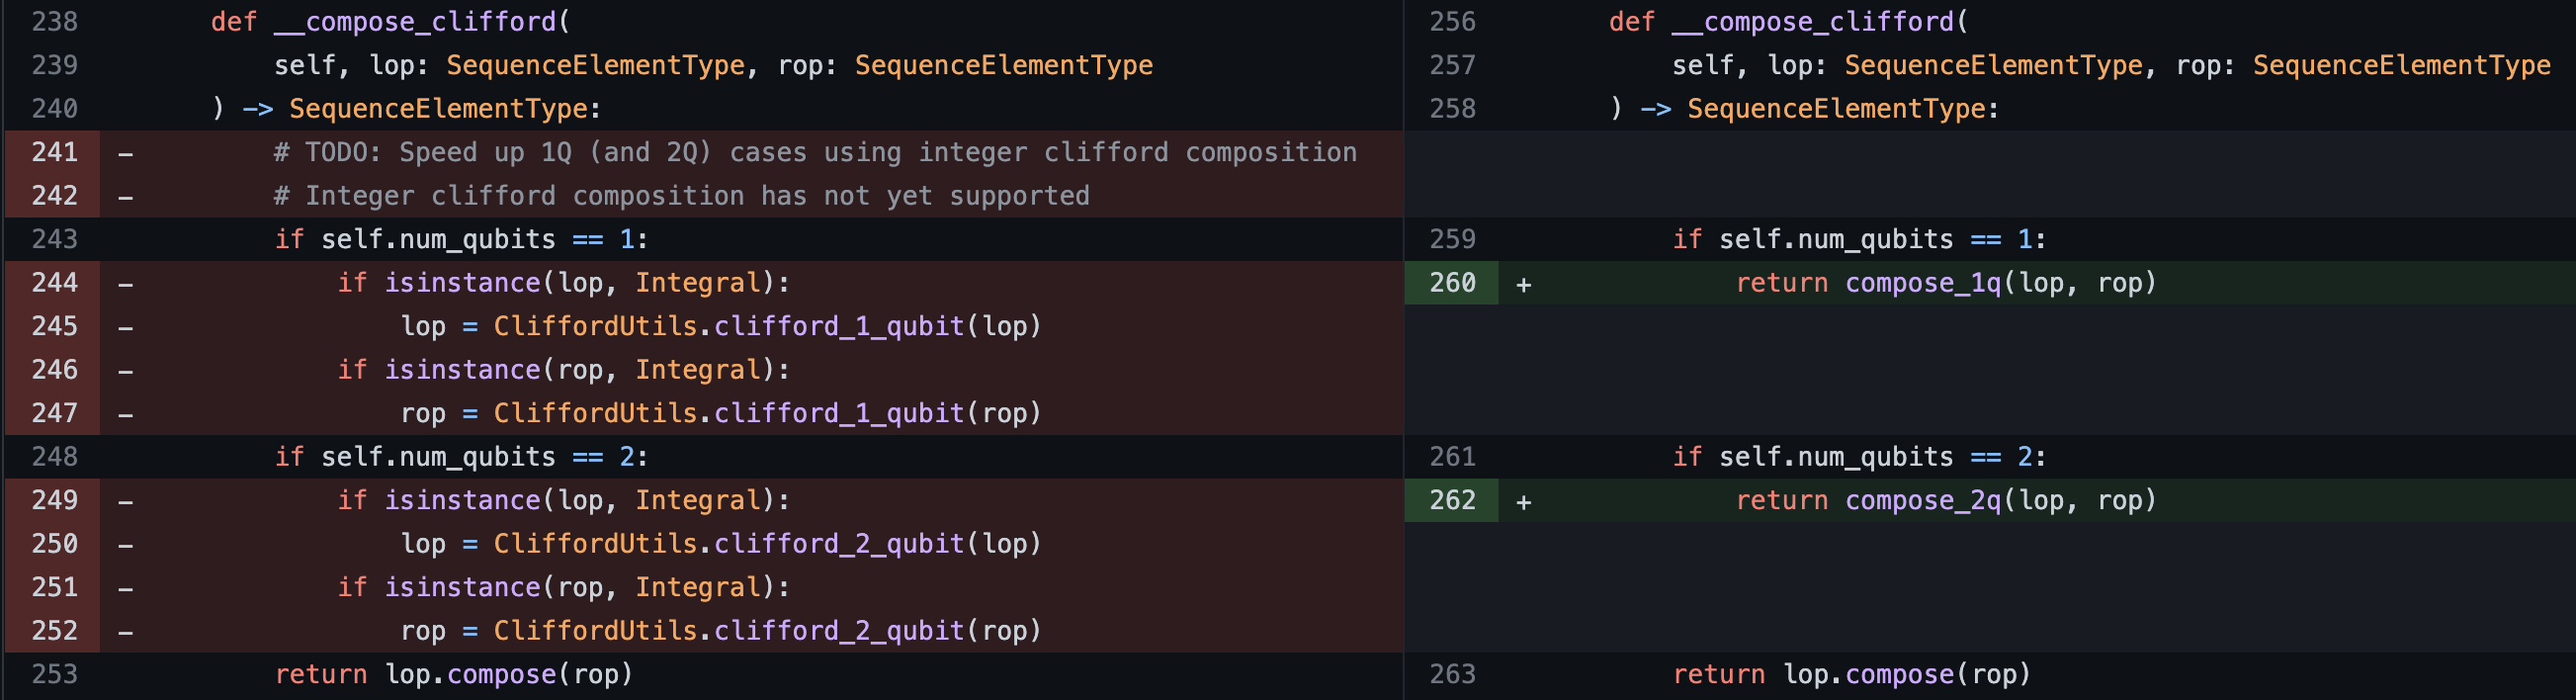
where `SequenceElementType = Union[Clifford, Integral, QuantumCircuit]`

In [ ]:
def compose_1q(lhs: Integral, rhs: Integral) -> Integral:
    """Return the composition of 1-qubit clifford integers."""
    return _CLIFFORD_COMPOSE_1Q[lhs, rhs]

In [ ]:
def compose_2q(lhs: Integral, rhs: Integral) -> Integral:
    """Return the composition of 2-qubit clifford integers."""
    num = lhs
    for layer, idx in enumerate(_layer_indices_from_num(rhs)):
        circ = _CLIFFORD_LAYER[layer][idx]
        num = _compose_num_with_circuit_2q(num, circ)
    return num

def _compose_num_with_circuit_2q(num: Integral, qc: QuantumCircuit) -> Integral:
    """Compose a number that represents a Clifford, with a Clifford circuit, and return the
    number that represents the resulting Clifford."""
    lhs = num
    for inst in qc:
        qubits = tuple(qc.find_bit(q).index for q in inst.qubits)
        rhs = _num_from_2q_gate(op=inst.operation, qubits=qubits)
        try:
            lhs = _CLIFFORD_COMPOSE_2Q_GATE[lhs, rhs]
        except KeyError as err:
            raise Exception(f"_CLIFFORD_COMPOSE_2Q_GATE[{lhs}][{rhs}]") from err
    return lhs

# Recap: How to run RB experiment

In [1]:
from qiskit.providers.fake_provider import FakeManila
from qiskit_experiments.library.randomized_benchmarking import StandardRB
backend=FakeManila()

Adding a job from a backend (aer_simulator) that is different than the current backend (<qiskit.providers.backend_compat.BackendV2Converter object at 0x13a309dc0>). The new backend will be used, but service is not changed if one already exists.


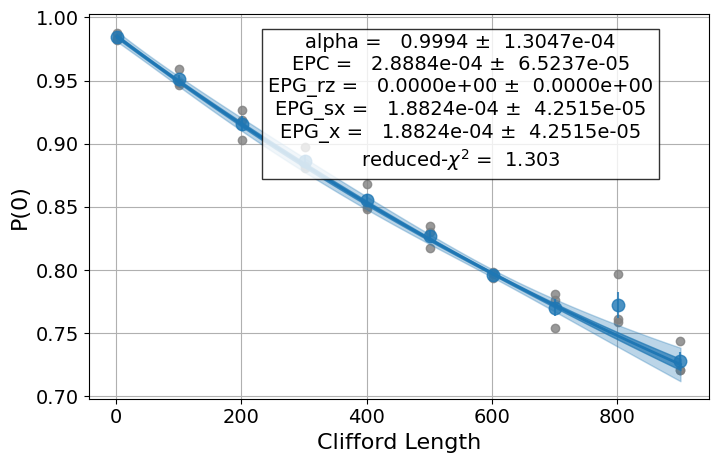

CPU times: user 5.57 s, sys: 1.8 s, total: 7.37 s
Wall time: 3.61 s


In [2]:
%%time
# create experiment
exp = StandardRB(
    qubits=[3],
    lengths=list(range(1, 1000, 100)),
    num_samples=3,
    seed=1234,
    backend=backend,
)
# run experiment
expdata = exp.run().block_for_results()
display(expdata.figure(0))

# Performance improvement

- Compare `rb_speedup` branch ("after") with `main` branch  ("before") 
- Focus on the time to generate transpiled circuits (No updates in the subsequent steps)
- Benchmark Standard 1Q/2Q RB, Interleaved 1Q/2Q RB (No updates in RB with 3 or more qubits)

Code snipet of a benchmark for Standard 1Q RB: 

In [1]:
num_lengths = 10
# run several experiments with changing max clifford length (max_length)
for max_length in [1000, 2000, 3000, 4000, 5000]:  # [100, 200, 300, 400, 500] for 2Q RBs
    exp = StandardRB(
        qubits=[2],  # for 1Q RBs ([2, 1] for 2Q RBs)
        lengths=np.arange(1, max_length, max_length // num_lengths),  # see below for examples
        backend=FakeManilaV2(),
        num_samples=3,
        full_sampling=False,
    )
    # measure the time to generate transpiled RB circuits
    exp._transpiled_circuits()

In [3]:
import numpy as np
max_length, num_lengths = 1000, 10
print(np.arange(1, max_length, max_length // num_lengths))  # = range(1, 1000, 100)
max_clifford_length, num_lengths = 2000, 10
print(np.arange(1, max_length, max_length // num_lengths))  # = range(1, 2000, 100)

[  1 101 201 301 401 501 601 701 801 901]
[   1  201  401  601  801 1001 1201 1401 1601 1801]


### Benchmark results

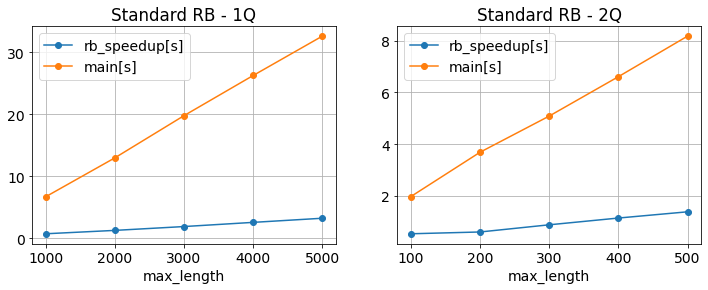
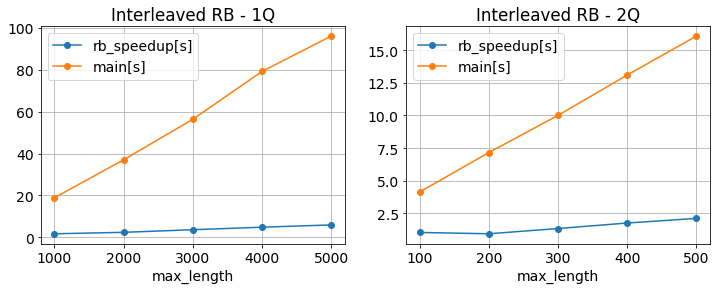
(SXGate and CXGate are interleaved for 1Q and 2Q Interleaved RB, respectively.)

Roughly, 10x speedup in 1Q RBs and 5x speedup in 2Q RBs !!

# An important note on RB with calibrated gate
In order to obtain this speed-up, you should not overwrite the default transpile options.

For example, if you are benchmarking your gate calibration, you should use `InstructionProperties.calibration` in `BackendV2` instead of `inst_map` in transpile otpions.

In [7]:
import copy
from qiskit.circuit.library.standard_gates import SXGate
from qiskit.providers.fake_provider import FakeManilaV2
from qiskit.pulse import Schedule, InstructionScheduleMap
from qiskit_experiments.library.randomized_benchmarking import StandardRB

In [1]:
qubits=(2,)
lengths=list(range(1, 1000, 100))
num_samples=3
seed=777
backend = FakeManilaV2()

Fast - Using `InstructionProperties.calibration` in `BackendV2`

In [6]:
%%time
qubits = (2,)
my_sched = Schedule(name="custom_sx_gate")
my_backend = copy.deepcopy(backend)
my_backend.target["sx"][qubits].calibration = my_sched

exp = StandardRB(qubits=qubits, lengths=lengths, num_samples=num_samples, backend=my_backend)
transpiled = exp._transpiled_circuits()

CPU times: user 1.54 s, sys: 26.8 ms, total: 1.57 s
Wall time: 1.57 s


Slow - Using `inst_map` in transpile otpions

In [8]:
%%time
qubits = (2,)
my_sched = Schedule(name="custom_sx_gate")
my_inst_map = InstructionScheduleMap()
my_inst_map.add(SXGate(), qubits, my_sched)

exp = StandardRB(qubits=qubits, lengths=lengths, num_samples=num_samples, backend=backend)
exp.set_transpile_options(inst_map=my_inst_map)
transpiled = exp._transpiled_circuits()

CPU times: user 9.72 s, sys: 59.9 ms, total: 9.78 s
Wall time: 9.8 s


## Summary
- Achieved drastic performance improvement in (transpiled) circuit generation for 1Q/2Q RB (no for 3Q or more RB)
    - About 5x--10x speedup comparing with previous qiskit-experiments (or Ignis)
    - By implementing custom transpilation and interger-based Clifford operations
- To enjoy this speedup, you should not overwrite the default transpile options
    - Recommend to use `InstructionProperties.calibration` in `BackendV2` instead of `inst_map` in transpile otpions when benchmarking your gate calibration

# Backup
- More examples of running experiments
- Comparison with Ignis: Found almost the same speedup as `main` -> `rb_speedup`.

In [1]:
from qiskit_experiments.library.randomized_benchmarking import StandardRB, InterleavedRB
from qiskit.providers.fake_provider import FakeManila

## Standard 1Q RB

In [2]:
qubits=[2]
lengths=list(range(1, 1000, 100))
num_samples=3
seed=777
backend = FakeManila()
print("Cliford lengths:", lengths)
print("Number of circuits =", len(lengths)*num_samples)

Cliford lengths: [1, 101, 201, 301, 401, 501, 601, 701, 801, 901]
Number of circuits = 30


In [3]:
%%time
# rb_speedup
exp = StandardRB(
    qubits=qubits,
    lengths=lengths,
    num_samples=num_samples,
    seed=seed,
    backend=backend,
)
transpiled = exp._transpiled_circuits()

CPU times: user 1.86 s, sys: 70.3 ms, total: 1.93 s
Wall time: 1.93 s


In [5]:
# %%time
# # Main
# exp = StandardRB(
#     qubits=qubits,
#     lengths=lengths,
#     num_samples=num_samples,
#     seed=seed,
#     backend=backend,
# )
# transpiled = exp._transpiled_circuits()

CPU times: user 8.94 s, sys: 139 ms, total: 9.08 s
Wall time: 9.22 s


## Standard 2Q RB

In [4]:
qubits=[3, 2]
lengths=list(range(1, 200, 20))
num_samples=3
seed=777
backend = FakeManila()
print("Cliford lengths:", lengths)
print("Number of circuits =", len(lengths)*num_samples)

Cliford lengths: [1, 21, 41, 61, 81, 101, 121, 141, 161, 181]
Number of circuits = 30


In [5]:
%%time
# rb_speedup
exp = StandardRB(
    qubits=qubits,
    lengths=lengths,
    num_samples=num_samples,
    seed=seed,
    backend=backend,
)
transpiled = exp._transpiled_circuits()

CPU times: user 1.29 s, sys: 15 ms, total: 1.3 s
Wall time: 1.3 s


In [8]:
# %%time
# # Main
# exp = StandardRB(
#     qubits=qubits,
#     lengths=lengths,
#     num_samples=num_samples,
#     seed=seed,
#     backend=backend,
# )
# transpiled = exp._transpiled_circuits()

CPU times: user 4.37 s, sys: 30 ms, total: 4.4 s
Wall time: 4.41 s


## Interleaved 1Q RB

In [6]:
from qiskit.circuit import Delay
qubits=[2]
lengths=list(range(1, 1000, 100))
num_samples=3
seed=777
backend = FakeManila()
print("Cliford lengths:", lengths)
print("Number of circuits =", len(lengths)*num_samples*2)

Cliford lengths: [1, 101, 201, 301, 401, 501, 601, 701, 801, 901]
Number of circuits = 60


In [7]:
from qiskit_experiments.framework.backend_timing import BackendTiming
timing = BackendTiming(backend)
duration_in_dt = timing.round_delay(time=backend.properties().gate_length("sx", qubits))  # 160[dt]

In [8]:
%%time
# rb_speedup
exp = InterleavedRB(
    interleaved_element=Delay(duration=duration_in_dt),
    qubits=qubits,
    lengths=lengths,
    num_samples=num_samples,
    seed=seed,
    backend=backend,
)
transpiled = exp._transpiled_circuits()

CPU times: user 1.96 s, sys: 15.2 ms, total: 1.98 s
Wall time: 1.98 s


In [12]:
# %%time
# # Main
# exp = InterleavedRB(
#     interleaved_element=Delay(duration=duration_in_dt),
#     qubits=qubits,
#     lengths=lengths,
#     num_samples=num_samples,
#     seed=seed,
#     backend=backend,
# )
# transpiled = exp._transpiled_circuits()

CPU times: user 18.4 s, sys: 101 ms, total: 18.5 s
Wall time: 18.5 s


## Interleaved 2Q RB

In [9]:
qubits=[3, 2]
lengths=list(range(1, 200, 20))
num_samples=3
seed=777
backend = FakeManila()
print("Cliford lengths:", lengths)
print("Number of circuits =", len(lengths)*num_samples*2)

Cliford lengths: [1, 21, 41, 61, 81, 101, 121, 141, 161, 181]
Number of circuits = 60


In [10]:
from qiskit.circuit import Delay, QuantumCircuit
delay_qc = QuantumCircuit(2)
delay_qc.delay(1600, 0)
delay_qc.delay(1600, 1)
delay_qc.draw()

┌─────────────────┐
q_0: ┤ Delay(1600[dt]) ├
     ├─────────────────┤
q_1: ┤ Delay(1600[dt]) ├
     └─────────────────┘

In [11]:
%%time
# rb_speedup
exp = InterleavedRB(
    interleaved_element=delay_qc,
    qubits=qubits,
    lengths=lengths,
    num_samples=num_samples,
    seed=seed,
    backend=backend,
)
transpiled = exp._transpiled_circuits()

CPU times: user 1.27 s, sys: 8.73 ms, total: 1.28 s
Wall time: 1.28 s


In [16]:
# %%time
# # Main
# exp = InterleavedRB(
#     interleaved_element=delay_qc,
#     qubits=qubits,
#     lengths=lengths,
#     num_samples=num_samples,
#     seed=seed,
#     backend=backend,
# )
# transpiled = exp._transpiled_circuits()

CPU times: user 9.93 s, sys: 42.6 ms, total: 9.97 s
Wall time: 10 s


# Comparing RB performance with Ignis
Time to generate transpiled circuits by qiskit-experiments are faster than that by Ignis

In [1]:
from qiskit.compiler import transpile
from qiskit.providers.fake_provider import FakeManila

## Standard 1Q RB

In [2]:
# common RB configuration
qubits=[2]
lengths=list(range(1, 1000, 100))
num_samples=3
seed=777
backend = FakeManila()
print("Cliford lengths:", lengths)
print("Number of circuits =", len(lengths)*num_samples)

Cliford lengths: [1, 101, 201, 301, 401, 501, 601, 701, 801, 901]
Number of circuits = 30


In [3]:
from qiskit.ignis.verification import randomized_benchmarking as rb

<ipython-input-3-afb532565d0e>:1: DeprecationWarning: The qiskit.ignis package is deprecated and has been supersceded by the qiskit-experiments project. Refer to the migration guide: https://github.com/Qiskit/qiskit-ignis#migration-guide on how to migrate to the new project.
  from qiskit.ignis.verification import randomized_benchmarking as rb


In [4]:
%%time
# Ignis
# create the RB circuits
circs, _ = rb.randomized_benchmarking_seq(
    rb_pattern=[qubits],
    length_vector=lengths,
    nseeds=num_samples,
    seed_offset=seed,
)
# transpile (for basis translation)
transpiled = []
for qcs in circs:
    for qc in qcs:
        transpiled.append(transpile(qc, backend=backend, optimization_level=0))

CPU times: user 5.88 s, sys: 91.9 ms, total: 5.97 s
Wall time: 5.98 s


In [5]:
# transpiled[0].draw(idle_wires=False)

global phase: π/2
          ┌─────────┐┌─────────┐┌────┐┌─────────┐┌─────────┐ ░ ┌──────────┐»
qr_2 -> 2 ┤ Rz(π/2) ├┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├┤ Rz(π/2) ├─░─┤ Rz(-π/2) ├»
          └─────────┘└─────────┘└────┘└─────────┘└─────────┘ ░ └──────────┘»
      cr: ═════════════════════════════════════════════════════════════════»
                                                                           »
«          ┌─────────┐┌────┐┌─────────┐┌──────────┐┌─┐
«qr_2 -> 2 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├┤ Rz(-π/2) ├┤M├
«          └─────────┘└────┘└─────────┘└──────────┘└╥┘
«      cr: ═════════════════════════════════════════╩═
«

In [6]:
from qiskit_experiments.library.randomized_benchmarking import StandardRB, InterleavedRB

In [7]:
%%time
# Experiments
# create experiment object
exp = StandardRB(
    qubits=qubits,
    lengths=lengths,
    num_samples=num_samples,
    seed=seed,
    backend=backend,
)
# compute transpiled circuits
transpiled_qe = exp._transpiled_circuits()

CPU times: user 1.42 s, sys: 27 ms, total: 1.45 s
Wall time: 1.45 s


In [8]:
# transpiled_qe[0].draw(idle_wires=False)

global phase: 7π/4
       ░ ┌─────────┐┌────┐┌─────────┐┌─────────┐┌─────────┐┌────┐┌─────────┐»
 q_2: ─░─┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├┤ Rz(π/2) ├┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├»
       ░ └─────────┘└────┘└─────────┘└─────────┘└─────────┘└────┘└─────────┘»
meas: ══════════════════════════════════════════════════════════════════════»
                                                                            »
«      ┌─────────┐┌───────┐ ░ ┌─────────┐┌────┐┌─────────┐┌─────────┐»
« q_2: ┤ Rz(π/2) ├┤ Rz(π) ├─░─┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├┤ Rz(π/2) ├»
«      └─────────┘└───────┘ ░ └─────────┘└────┘└─────────┘└─────────┘»
«meas: ══════════════════════════════════════════════════════════════»
«                                                                    »
«      ┌─────────┐┌────┐┌────────┐┌────┐┌──────────┐ ░ ┌─┐
« q_2: ┤ Rz(π/2) ├┤ √X ├┤ Rz(2π) ├┤ √X ├┤ Rz(7π/2) ├─░─┤M├
«      └─────────┘└────┘└────────┘└────┘└──────────┘ ░ └╥┘
«meas: ═════════════════════════════════════════════════╩═
«

## Standard 2Q RB

In [9]:
# common RB configuration
qubits=[3, 2]
lengths=list(range(1, 200, 20))
num_samples=3
seed=777
backend = FakeManila()
print("Cliford lengths:", lengths)
print("Number of circuits =", len(lengths)*num_samples)

Cliford lengths: [1, 21, 41, 61, 81, 101, 121, 141, 161, 181]
Number of circuits = 30


In [10]:
from qiskit.ignis.verification import randomized_benchmarking as rb

In [11]:
%%time
# Ignis
# create the RB circuits
circs, _ = rb.randomized_benchmarking_seq(
    rb_pattern=[qubits],
    length_vector=lengths,
    nseeds=num_samples,
    seed_offset=seed,
)
# transpile (for basis translation)
transpiled = []
for qcs in circs:
    for qc in qcs:
        transpiled.append(transpile(qc, backend=backend, optimization_level=0))

CPU times: user 5.18 s, sys: 31.6 ms, total: 5.21 s
Wall time: 5.22 s


In [12]:
# transpiled[0].draw(idle_wires=False)

global phase: π
          ┌───────┐┌─────────┐┌─────────┐┌────┐┌─────────┐┌─────────┐┌───┐»
qr_2 -> 2 ┤ Rz(π) ├┤ Rz(π/2) ├┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├┤ Rz(π/2) ├┤ X ├»
          └───────┘└─────────┘└─────────┘└────┘└─────────┘└─────────┘└─┬─┘»
qr_3 -> 3 ─────────────────────────────────────────────────────────────■──»
                                                                          »
    cr_0: ════════════════════════════════════════════════════════════════»
                                                                          »
    cr_1: ════════════════════════════════════════════════════════════════»
                                                                          »
«          ┌─────────┐    ┌────┐  ┌─────────┐┌─────────┐┌───┐                 »
«qr_2 -> 2 ┤ Rz(π/2) ├────┤ √X ├──┤ Rz(π/2) ├┤ Rz(π/2) ├┤ X ├─────────────────»
«          ├─────────┴┐┌──┴────┴─┐└──┬────┬─┘├─────────┤└─┬─┘┌─────────┐┌────┐»
«qr_3 -> 3 ┤ Rz(-π/2) ├┤ Rz(π/2) ├───┤ √X ├──┤ Rz(π/2) ├──■──┤ Rz(π/2) ├┤ √X ├»
«          └──────────┘└─────────┘   └────┘  └─────────┘     └─────────┘└────┘»
«    cr_0: ═══════════════════════════════════════════════════════════════════»
«                                                                             »
«    cr_1: ═══════════════════════════════════════════════════════════════════»
«                                                                             »
«                                 ░                                         »
«qr_2 -> 2 ───────────────────────░─────────────────────────────────────────»
«          ┌─────────┐┌─────────┐ ░ ┌──────────┐┌─────────┐┌────┐┌─────────┐»
«qr_3 -> 3 ┤ Rz(π/2) ├┤ Rz(π/2) ├─░─┤ Rz(-π/2) ├┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├»
«          └─────────┘└─────────┘ ░ └──────────┘└─────────┘└────┘└─────────┘»
«    cr_0: ═════════════════════════════════════════════════════════════════»
«                                                                           »
«    cr_1: ═════════════════════════════════════════════════════════════════»
«                                                                           »
«          ┌───┐┌──────────┐┌─────────┐   ┌────┐  ┌─────────┐┌───┐┌──────────┐»
«qr_2 -> 2 ┤ X ├┤ Rz(-π/2) ├┤ Rz(π/2) ├───┤ √X ├──┤ Rz(π/2) ├┤ X ├┤ Rz(-π/2) ├»
«          └─┬─┘├─────────┬┘└──┬────┬─┘┌──┴────┴─┐├─────────┤└─┬─┘└───┬─┬────┘»
«qr_3 -> 3 ──■──┤ Rz(π/2) ├────┤ √X ├──┤ Rz(π/2) ├┤ Rz(π/2) ├──■──────┤M├─────»
«               └─────────┘    └────┘  └─────────┘└─────────┘         └╥┘     »
«    cr_0: ════════════════════════════════════════════════════════════╩══════»
«                                                                             »
«    cr_1: ═══════════════════════════════════════════════════════════════════»
«                                                                             »
«          ┌─────────┐┌────┐┌─────────┐┌──────────┐┌───────┐┌─┐
«qr_2 -> 2 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├┤ Rz(-π/2) ├┤ Rz(π) ├┤M├
«          └─────────┘└────┘└─────────┘└──────────┘└───────┘└╥┘
«qr_3 -> 3 ──────────────────────────────────────────────────╫─
«                                                            ║ 
«    cr_0: ══════════════════════════════════════════════════╬═
«                                                            ║ 
«    cr_1: ══════════════════════════════════════════════════╩═
«

In [13]:
from qiskit_experiments.library.randomized_benchmarking import StandardRB, InterleavedRB

In [14]:
%%time
# Experiments
# create experiment object
exp = StandardRB(
    qubits=qubits,
    lengths=lengths,
    num_samples=num_samples,
    seed=seed,
    backend=backend,
)
# compute transpiled circuits
transpiled_qe = exp._transpiled_circuits()

CPU times: user 1.15 s, sys: 13.9 ms, total: 1.16 s
Wall time: 1.17 s


In [15]:
# transpiled_qe[0].draw(idle_wires=False)

global phase: π
         ░ ┌─────────┐┌────┐┌─────────┐┌─────────┐    ┌────┐  ┌─────────┐»
   q_2: ─░─┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├┤ Rz(π/2) ├────┤ √X ├──┤ Rz(π/2) ├»
         ░ ├─────────┤├────┤├─────────┤├─────────┴┐┌──┴────┴─┐└──┬────┬─┘»
   q_3: ─░─┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├┤ Rz(-π/2) ├┤ Rz(π/2) ├───┤ √X ├──»
         ░ └─────────┘└────┘└─────────┘└──────────┘└─────────┘   └────┘  »
meas_0: ═════════════════════════════════════════════════════════════════»
                                                                         »
meas_1: ═════════════════════════════════════════════════════════════════»
                                                                         »
«        ┌─────────┐┌───┐     ┌─────────┐┌────┐┌─────────┐┌─────────┐»
«   q_2: ┤ Rz(π/2) ├┤ X ├──■──┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├┤ Rz(π/2) ├»
«        ├─────────┤└─┬─┘┌─┴─┐├─────────┤├────┤└┬────────┤└──┬────┬─┘»
«   q_3: ┤ Rz(π/2) ├──■──┤ X ├┤ Rz(π/2) ├┤ √X ├─┤ Rz(2π) ├───┤ √X ├──»
«        └─────────┘     └───┘└─────────┘└────┘ └────────┘   └────┘  »
«meas_0: ════════════════════════════════════════════════════════════»
«                                                                    »
«meas_1: ════════════════════════════════════════════════════════════»
«                                                                    »
«           ┌───┐     ░ ┌─────────┐┌────┐┌─────────┐┌─────────┐┌────┐»
«   q_2: ───┤ X ├─────░─┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├┤ Rz(π/2) ├┤ √X ├»
«        ┌──┴───┴───┐ ░ ├─────────┤├────┤├─────────┤└─────────┘└────┘»
«   q_3: ┤ Rz(7π/2) ├─░─┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├─────────────────»
«        └──────────┘ ░ └─────────┘└────┘└─────────┘                 »
«meas_0: ════════════════════════════════════════════════════════════»
«                                                                    »
«meas_1: ════════════════════════════════════════════════════════════»
«                                                                    »
«        ┌─────────┐┌─────────┐┌───┐     ┌─────────┐    ┌────┐  ┌─────────┐»
«   q_2: ┤ Rz(π/2) ├┤ Rz(π/2) ├┤ X ├──■──┤ Rz(π/2) ├────┤ √X ├──┤ Rz(π/2) ├»
«        └─────────┘└─────────┘└─┬─┘┌─┴─┐├─────────┴┐┌──┴────┴─┐└──┬────┬─┘»
«   q_3: ────────────────────────■──┤ X ├┤ Rz(-π/2) ├┤ Rz(π/2) ├───┤ √X ├──»
«                                   └───┘└──────────┘└─────────┘   └────┘  »
«meas_0: ══════════════════════════════════════════════════════════════════»
«                                                                          »
«meas_1: ══════════════════════════════════════════════════════════════════»
«                                                                          »
«        ┌─────────┐   ┌───┐                                      ░    ┌─┐
«   q_2: ┤ Rz(π/2) ├───┤ X ├──────────────────────────────────────░────┤M├
«        ├─────────┤┌──┴───┴──┐┌────┐┌────────┐┌────┐┌──────────┐ ░ ┌─┐└╥┘
«   q_3: ┤ Rz(π/2) ├┤ Rz(π/2) ├┤ √X ├┤ Rz(2π) ├┤ √X ├┤ Rz(7π/2) ├─░─┤M├─╫─
«        └─────────┘└─────────┘└────┘└────────┘└────┘└──────────┘ ░ └╥┘ ║ 
«meas_0: ════════════════════════════════════════════════════════════╩══╬═
«                                                                       ║ 
«meas_1: ═══════════════════════════════════════════════════════════════╩═
«

## Interleaved 1Q RB

In [16]:
# common RB configuration
from qiskit.circuit import Delay
qubits=[2]
lengths=list(range(1, 1000, 100))
num_samples=3
seed=777
backend = FakeManila()
print("Cliford lengths:", lengths)
print("Number of circuits =", len(lengths)*num_samples*2)

Cliford lengths: [1, 101, 201, 301, 401, 501, 601, 701, 801, 901]
Number of circuits = 60


In [17]:
%%time
# Ignis
# create the RB circuits
circuits, xdata, circuits_interleaved = rb.randomized_benchmarking_seq(
    rb_pattern=[qubits],
    length_vector=lengths,
    nseeds=num_samples,
    seed_offset=seed,
    interleaved_elem=[Delay(duration=160)]
)
# transpile (for basis translation)
transpiled = []
for qcs in circuits:
    for qc in qcs:
        transpiled.append(transpile(qc, backend=backend, optimization_level=0))
for qcs in circuits_interleaved:
    for qc in qcs:
        transpiled.append(transpile(qc, backend=backend, optimization_level=0))

CPU times: user 14 s, sys: 83.7 ms, total: 14.1 s
Wall time: 14.1 s


In [18]:
# transpiled[30].draw(idle_wires=False)

global phase: 3π/2
          ┌───────┐┌─────────┐┌────┐┌─────────┐┌─────────┐ ░ ┌────────────────┐»
qr_2 -> 2 ┤ Rz(π) ├┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├┤ Rz(π/2) ├─░─┤ Delay(160[dt]) ├»
          └───────┘└─────────┘└────┘└─────────┘└─────────┘ ░ └────────────────┘»
      cr: ═════════════════════════════════════════════════════════════════════»
                                                                               »
«           ░ ┌──────────┐┌─────────┐┌────┐┌─────────┐┌───────┐┌─┐
«qr_2 -> 2 ─░─┤ Rz(-π/2) ├┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├┤ Rz(π) ├┤M├
«           ░ └──────────┘└─────────┘└────┘└─────────┘└───────┘└╥┘
«      cr: ═════════════════════════════════════════════════════╩═
«

In [19]:
%%time
# Experiments
from qiskit_experiments.framework.backend_timing import BackendTiming

timing = BackendTiming(backend)
duration_in_dt = timing.round_delay(time=backend.properties().gate_length("sx", qubits))  # 160[dt]

# create experiment object
exp = InterleavedRB(
    interleaved_element=Delay(duration=duration_in_dt),
    qubits=qubits,
    lengths=lengths,
    num_samples=num_samples,
    seed=seed,
    backend=backend,
)
# compute transpiled circuits
transpiled_qe = exp._transpiled_circuits()

CPU times: user 1.79 s, sys: 19.7 ms, total: 1.81 s
Wall time: 1.81 s


In [20]:
# transpiled_qe[30].draw(idle_wires=False)

global phase: 7π/4
       ░ ┌─────────┐┌────┐┌─────────┐┌─────────┐┌─────────┐┌────┐┌─────────┐»
 q_2: ─░─┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├┤ Rz(π/2) ├┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├»
       ░ └─────────┘└────┘└─────────┘└─────────┘└─────────┘└────┘└─────────┘»
meas: ══════════════════════════════════════════════════════════════════════»
                                                                            »
«      ┌─────────┐┌───────┐ ░ ┌────────────────┐ ░ ┌─────────┐┌────┐┌─────────┐»
« q_2: ┤ Rz(π/2) ├┤ Rz(π) ├─░─┤ Delay(160[dt]) ├─░─┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├»
«      └─────────┘└───────┘ ░ └────────────────┘ ░ └─────────┘└────┘└─────────┘»
«meas: ════════════════════════════════════════════════════════════════════════»
«                                                                              »
«      ┌─────────┐┌─────────┐┌────┐┌────────┐┌────┐┌──────────┐ ░ ┌─┐
« q_2: ┤ Rz(π/2) ├┤ Rz(π/2) ├┤ √X ├┤ Rz(2π) ├┤ √X ├┤ Rz(7π/2) ├─░─┤M├
«      └─────────┘└─────────┘└────┘└────────┘└────┘└──────────┘ ░ └╥┘
«meas: ════════════════════════════════════════════════════════════╩═
«

In [21]:
duration_in_dt

160

In [22]:
timing.round_delay(time=100e-9)  # 100[ns] == 450[dt]

450

## Interleaved 2Q RB

In [29]:
# common RB configuration
from qiskit.circuit import Delay, QuantumCircuit
qubits=[3, 2]
lengths=list(range(1, 200, 20))
num_samples=3
seed=777
backend = FakeManila()
print("Cliford lengths:", lengths)
print("Number of circuits =", len(lengths)*num_samples*2)

Cliford lengths: [1, 21, 41, 61, 81, 101, 121, 141, 161, 181]
Number of circuits = 60


In [30]:
delay_qc = QuantumCircuit(2)
delay_qc.delay(1600, 0)
delay_qc.delay(1600, 1)
delay_qc.draw()

┌─────────────────┐
q_0: ┤ Delay(1600[dt]) ├
     ├─────────────────┤
q_1: ┤ Delay(1600[dt]) ├
     └─────────────────┘

In [31]:
%%time
# Ignis
# create the RB circuits
circuits, xdata, circuits_interleaved = rb.randomized_benchmarking_seq(
    rb_pattern=[qubits],
    length_vector=lengths,
    nseeds=num_samples,
    seed_offset=seed,
    interleaved_elem=[delay_qc]
)
# transpile (for basis translation)
transpiled = []
for qcs in circuits:
    for qc in qcs:
        transpiled.append(transpile(qc, backend=backend, optimization_level=0))
for qcs in circuits_interleaved:
    for qc in qcs:
        transpiled.append(transpile(qc, backend=backend, optimization_level=0))

CPU times: user 11.8 s, sys: 56.4 ms, total: 11.9 s
Wall time: 11.8 s


In [32]:
# transpiled[30].draw(idle_wires=False)

global phase: 0
            ┌───┐  ┌─────────┐┌────┐┌─────────┐┌─────────┐┌───┐ ░ »
qr_2 -> 2 ──┤ X ├──┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├┤ Rz(π/2) ├┤ X ├─░─»
          ┌─┴───┴─┐├─────────┤├────┤├─────────┤├─────────┤└─┬─┘ ░ »
qr_3 -> 3 ┤ Rz(π) ├┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├┤ Rz(π/2) ├──■───░─»
          └───────┘└─────────┘└────┘└─────────┘└─────────┘      ░ »
    cr_0: ════════════════════════════════════════════════════════»
                                                                  »
    cr_1: ════════════════════════════════════════════════════════»
                                                                  »
«          ┌─────────────────┐ ░ ┌───┐┌──────────┐┌─────────┐┌────┐┌─────────┐»
«qr_2 -> 2 ┤ Delay(1600[dt]) ├─░─┤ X ├┤ Rz(-π/2) ├┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├»
«          ├─────────────────┤ ░ └─┬─┘├──────────┤├─────────┤├────┤├─────────┤»
«qr_3 -> 3 ┤ Delay(1600[dt]) ├─░───■──┤ Rz(-π/2) ├┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├»
«          └─────────────────┘ ░      └──────────┘└─────────┘└────┘└─────────┘»
«    cr_0: ═══════════════════════════════════════════════════════════════════»
«                                                                             »
«    cr_1: ═══════════════════════════════════════════════════════════════════»
«                                                                             »
«            ┌───┐     ┌─┐
«qr_2 -> 2 ──┤ X ├─────┤M├
«          ┌─┴───┴─┐┌─┐└╥┘
«qr_3 -> 3 ┤ Rz(π) ├┤M├─╫─
«          └───────┘└╥┘ ║ 
«    cr_0: ══════════╩══╬═
«                       ║ 
«    cr_1: ═════════════╩═
«

In [33]:
%%time
# Experiments
# create experiment object
exp = InterleavedRB(
    interleaved_element=delay_qc,
    qubits=qubits,
    lengths=lengths,
    num_samples=num_samples,
    seed=seed,
    backend=backend,
)
# compute transpiled circuits
transpiled_qe = exp._transpiled_circuits()

CPU times: user 1.27 s, sys: 19.3 ms, total: 1.28 s
Wall time: 1.29 s


In [34]:
# transpiled_qe[30].draw(idle_wires=False)

global phase: π
         ░ ┌─────────┐┌────┐┌─────────┐┌─────────┐    ┌────┐  ┌─────────┐»
   q_2: ─░─┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├┤ Rz(π/2) ├────┤ √X ├──┤ Rz(π/2) ├»
         ░ ├─────────┤├────┤├─────────┤├─────────┴┐┌──┴────┴─┐└──┬────┬─┘»
   q_3: ─░─┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├┤ Rz(-π/2) ├┤ Rz(π/2) ├───┤ √X ├──»
         ░ └─────────┘└────┘└─────────┘└──────────┘└─────────┘   └────┘  »
meas_0: ═════════════════════════════════════════════════════════════════»
                                                                         »
meas_1: ═════════════════════════════════════════════════════════════════»
                                                                         »
«        ┌─────────┐┌───┐     ┌─────────┐┌────┐┌─────────┐┌─────────┐»
«   q_2: ┤ Rz(π/2) ├┤ X ├──■──┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├┤ Rz(π/2) ├»
«        ├─────────┤└─┬─┘┌─┴─┐├─────────┤├────┤└┬────────┤└──┬────┬─┘»
«   q_3: ┤ Rz(π/2) ├──■──┤ X ├┤ Rz(π/2) ├┤ √X ├─┤ Rz(2π) ├───┤ √X ├──»
«        └─────────┘     └───┘└─────────┘└────┘ └────────┘   └────┘  »
«meas_0: ════════════════════════════════════════════════════════════»
«                                                                    »
«meas_1: ════════════════════════════════════════════════════════════»
«                                                                    »
«           ┌───┐     ░ ┌─────────────────┐ ░ ┌─────────┐┌────┐┌─────────┐»
«   q_2: ───┤ X ├─────░─┤ Delay(1600[dt]) ├─░─┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├»
«        ┌──┴───┴───┐ ░ ├─────────────────┤ ░ ├─────────┤├────┤├─────────┤»
«   q_3: ┤ Rz(7π/2) ├─░─┤ Delay(1600[dt]) ├─░─┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├»
«        └──────────┘ ░ └─────────────────┘ ░ └─────────┘└────┘└─────────┘»
«meas_0: ═════════════════════════════════════════════════════════════════»
«                                                                         »
«meas_1: ═════════════════════════════════════════════════════════════════»
«                                                                         »
«        ┌─────────┐┌────┐┌─────────┐┌─────────┐┌───┐     ┌─────────┐ »
«   q_2: ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├┤ Rz(π/2) ├┤ X ├──■──┤ Rz(π/2) ├─»
«        └─────────┘└────┘└─────────┘└─────────┘└─┬─┘┌─┴─┐├─────────┴┐»
«   q_3: ─────────────────────────────────────────■──┤ X ├┤ Rz(-π/2) ├»
«                                                    └───┘└──────────┘»
«meas_0: ═════════════════════════════════════════════════════════════»
«                                                                     »
«meas_1: ═════════════════════════════════════════════════════════════»
«                                                                     »
«           ┌────┐  ┌─────────┐┌─────────┐   ┌───┐                         »
«   q_2: ───┤ √X ├──┤ Rz(π/2) ├┤ Rz(π/2) ├───┤ X ├─────────────────────────»
«        ┌──┴────┴─┐└──┬────┬─┘├─────────┤┌──┴───┴──┐┌────┐┌────────┐┌────┐»
«   q_3: ┤ Rz(π/2) ├───┤ √X ├──┤ Rz(π/2) ├┤ Rz(π/2) ├┤ √X ├┤ Rz(2π) ├┤ √X ├»
«        └─────────┘   └────┘  └─────────┘└─────────┘└────┘└────────┘└────┘»
«meas_0: ══════════════════════════════════════════════════════════════════»
«                                                                          »
«meas_1: ══════════════════════════════════════════════════════════════════»
«                                                                          »
«                     ░    ┌─┐
«   q_2: ─────────────░────┤M├
«        ┌──────────┐ ░ ┌─┐└╥┘
«   q_3: ┤ Rz(7π/2) ├─░─┤M├─╫─
«        └──────────┘ ░ └╥┘ ║ 
«meas_0: ════════════════╩══╬═
«                           ║ 
«meas_1: ═══════════════════╩═
«